# Define the system  

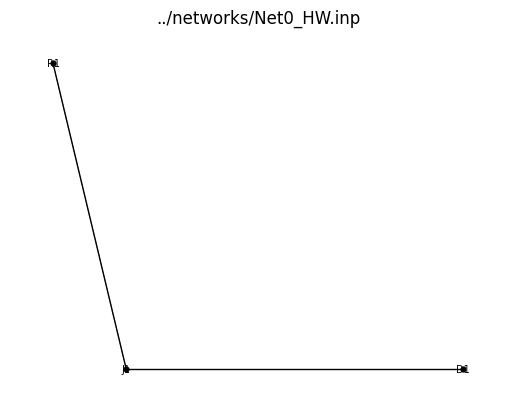

cons:
mass_balance[J1]:   ((expected_demand[J1]-flow[P1])+flow[P2])
mass_balance[D1]:   (expected_demand[D1]-flow[P2])
approx_hazen_williams_headloss[P1]:   (((((((-((sign(flow[P1]))))*hw_resistance[P1])*((abs(flow[P1]))**1.852))-((1e-05*(hw_resistance[P1]**0.5))*flow[P1]))-(((sign(flow[P1]))*minor_loss[P1])*(flow[P1]**2.0)))+source_head[R1])-head[J1])
approx_hazen_williams_headloss[P2]:   (((((((-((sign(flow[P2]))))*hw_resistance[P2])*((abs(flow[P2]))**1.852))-((1e-05*(hw_resistance[P2]**0.5))*flow[P2]))-(((sign(flow[P2]))*minor_loss[P2])*(flow[P2]**2.0)))+head[J1])-head[D1])

vars:
flow[P1]:   flow[P1]
flow[P2]:   flow[P2]
head[J1]:   head[J1]
head[D1]:   head[D1]



In [1]:
import wntr
import wntr_quantum
import numpy as np 
from wntr.sim.hydraulics import create_hydraulic_model

# Create a water network model
inp_file = '../networks/Net0_HW.inp'
# inp_file = '../networks/Net1Loops.inp'
# inp_file = '../networks/Net2Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

model, updater = create_hydraulic_model(wn, HW_approx='default')
print(model.__str__())


## Expression of he network

In [2]:


# Create a water network model
inp_file = '../networks/Net0_CM.inp'
# inp_file = '../networks/Net1Loops_CM.inp'
# inp_file = '../networks/Net2Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)



In [3]:
from wntr_quantum.scenario.network_qubo import Network
from qubols.solution_vector import SolutionVector_V2 as SolutionVector
from qubols.encodings import  RangedEfficientEncoding, PositiveQbitEncoding


nqbit = 3
range = (4/(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=0.25, offset=+0.0, var_base_name="x")
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=0.25, offset=+0.0, var_base_name="x")


net = Network(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)

In [4]:
ref_sol = net.classical_solutions()
ref_sol

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


array([1.5 , 1.  , 0.75, 0.25])

In [5]:
np.sort(flow_encoding.get_possible_values())

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75])

In [6]:
np.sort(head_encoding.get_possible_values())

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75])

In [7]:
from qubols.qubo_poly_mixed_variables import QUBO_POLY_MIXED
import sparse 
from dwave.samplers import SimulatedAnnealingSampler
from dwave.samplers import SteepestDescentSolver
from dwave.samplers import TabuSampler
from dimod import ExactSolver

# sampler = TabuSampler()
sampler = SimulatedAnnealingSampler()
# sampler = ExactSolver() 

qubo = QUBO_POLY_MIXED(net.mixed_solution_vector, options={"sampler" : sampler} )
matrices = tuple(sparse.COO(m) for m in net.matrices)

bqm = qubo.create_bqm(matrices, strength=1E6)

# sample
sampleset = qubo.sample_bqm(bqm, num_reads=5000)

# decode
sol  = qubo.decode_solution(sampleset.lowest().record[0][0])
sol = np.array(sol[0]+sol[1])
print(ref_sol)
print(sol)
print(ref_sol - sol)


[1.5  1.   0.75 0.25]
[1.5  1.   0.75 0.25]
[0.000e+00 2.220e-16 3.548e-11 3.803e-11]


In [13]:
qubo.mixed_solution_vectors.encoded_reals[0].variables

[x_001_001, x_001_002, x_001_003]

In [21]:
def compute_energy(qubo, vector, bqm):
    """Compue the QUBO energy of the vecto containing the solution of the initial problem

    Args:
        vector (_type_): _description_
    """
    closest_vec = []
    bin_encoding_vector = []
    encoded_variables = []
    for val, svec in zip(vector, qubo.mixed_solution_vectors.encoded_reals):
        closest_val, bin_encoding = svec.find_closest(val)
        closest_vec.append(closest_val)
        bin_encoding_vector += bin_encoding
        encoded_variables += svec.variables

    bqm_input_variables = []
    for v in bqm.variables:
        if v in encoded_variables:
            idx = encoded_variables.index(v)
            bqm_input_variables.append(bin_encoding_vector[idx])
        else:
            print(v)
            var0, var1 = v.split("*")
            idx0 = encoded_variables.index(var0)
            idx1 = encoded_variables.index(var1)
            val0, val1 = bin_encoding_vector[idx0], bin_encoding_vector[idx1]
            bqm_input_variables.append(val0 * val1)

    return closest_vec, bin_encoding_vector, encoded_variables

compute_energy(qubo, [1.5,0.9,0.6,0.3], bqm)

ValueError: not enough values to unpack (expected 2, got 1)

In [20]:
bqm.energy()

TypeError: energy() missing 1 required positional argument: 'sample'

In [8]:
flow_encoding.get_possible_values()

[5.0,
 -0.07936507936507908,
 5.079365079365079,
 2.7755575615628914e-16,
 5.158730158730159,
 0.07936507936507964,
 5.238095238095238,
 0.158730158730159,
 5.317460317460317,
 0.23809523809523836,
 5.396825396825396,
 0.3174603174603177,
 5.476190476190476,
 0.3968253968253971,
 5.555555555555555,
 0.47619047619047644,
 5.634920634920634,
 0.5555555555555558,
 5.7142857142857135,
 0.6349206349206351,
 5.793650793650794,
 0.7142857142857145,
 5.8730158730158735,
 0.7936507936507939,
 5.9523809523809526,
 0.8730158730158732,
 6.031746031746032,
 0.9523809523809526,
 6.111111111111111,
 1.031746031746032,
 6.19047619047619,
 1.1111111111111114,
 6.26984126984127,
 1.1904761904761907,
 6.349206349206349,
 1.26984126984127,
 6.428571428571429,
 1.3492063492063493,
 6.507936507936508,
 1.4285714285714288,
 6.587301587301587,
 1.5079365079365081,
 6.666666666666666,
 1.5873015873015874,
 6.746031746031746,
 1.666666666666667,
 6.825396825396825,
 1.7460317460317463,
 6.904761904761904,
 1.82

In [142]:
net.verify_solution(sol)

array([ 1.394, -0.5  ,  1.223, -2.109, -1.45 ,  0.204,  0.386, -0.138,  0.154])

In [15]:
import itertools
def find_closest(encoding, float):
    """get all the posible values encoded

    Returns:
        _type_: _description_
    """

    min_diff = 1E12
    closest_value = None 
    binary_encoding = None
    for data in itertools.product([0, 1], repeat=encoding.nqbit):
        val = encoding.decode_polynom(list(data)[::-1])
        if np.abs(val-float) < min_diff:
            min_diff  = np.abs(val-float)
            closest_value = val 
            binary_encoding = list(data)[::-1]

    return closest_value, binary_encoding 
vmin, bins = find_closest(flow_encoding, 2.)
vmin
bins

[1, 0, 1, 0, 1, 1, 0]

In [95]:
var = sampleset.lowest().variables
data = np.array(sampleset.lowest().record[0][0])
data_real_var = data[qubo.index_variables]

for v, d in zip(var, data):
    if v not in qubo.mapped_variables:
        x0, x1 = v.split('*')
        i0 = qubo.index_variables[qubo.mapped_variables.index(x0)]
        i1 = qubo.index_variables[qubo.mapped_variables.index(x1)]
        assert(d == data[i0] * data[i1])

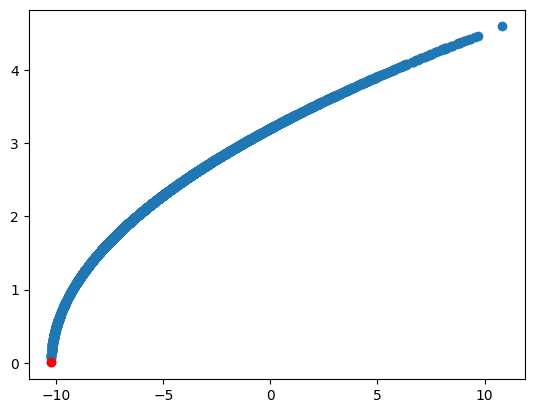

In [16]:
import matplotlib.pyplot as plt
energy = []
residue = []
for s in sampleset.record:
    energy.append(s[1])
    sol = qubo.decode_solution(s[0])
    r = net.verify_solution(np.array(sol).reshape(-1,))
    residue.append(np.linalg.norm(r))
plt.scatter(energy, (residue))

el, rl = [], []
for s in sampleset.lowest().record:
    el.append(s[1])
    sol = qubo.decode_solution(s[0])
    r = net.verify_solution(np.array(sol).reshape(-1,))
    rl.append(np.linalg.norm(r+1E-12))
plt.scatter(el, rl, c='red')

In [22]:
from qubols.qubo_poly import QUBO_POLY
from qubols.solution_vector import SolutionVector_V2 as SolutionVector
import sparse 
from dwave.samplers import SimulatedAnnealingSampler
from dwave.samplers import SteepestDescentSolver
from dwave.samplers import TabuSampler

encoding = RangedEfficientEncoding(nqbit=12, range=2.0, offset=0.0, var_base_name="x")
sol_vec = SolutionVector(4, encoding)

qubo = QUBO_POLY(solution_vector=sol_vec, options={ 'num_reads':1000, 'sampler':SimulatedAnnealingSampler()})
matrices = tuple(sparse.COO(m) for m in net.matrices)

bqm = qubo.create_bqm(matrices, strength=10000)

# sample
sampleset = qubo.sample_bqm(bqm, num_reads=5000)

# decode
sol  = qubo.decode_solution(sampleset.lowest().record[0][0])
sol = np.array(sol).reshape(-1)
print(ref_sol)
print(sol)
print(ref_sol - sol)


[1.5  1.   0.75 0.25]
[1.475 0.96  0.83  0.375]
[ 0.025  0.04  -0.08  -0.125]
